In [1]:
# Import Libraries & Load Data

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import re
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
# Download required NLTK data

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/lucy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lucy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lucy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/lucy/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
df = pd.read_excel("Assignment_Data.xlsx")
df.head()

,property_address,property_suburb,property_state,listing_description,listed_date,listed_price,days_on_market,number_of_beds,number_of_baths,number_of_parks,property_size,property_classification,property_sub_classification,suburb_days_on_market,suburb_median_price,price_outcome
0,"10/15 Childs Street, CLAYFIELD QLD 4011",CLAYFIELD,QLD,Living Among the Tree Tops! Enjoy the cooling ...,2022-03-24,475000,6,2,2.0,1.0,NaN,Unit,Apartment / Unit / Flat,NaN,NaN,Higher
1,"7 Oudeman Street, AUGUSTINE HEIGHTS QLD 4300",AUGUSTINE HEIGHTS,QLD,Poised To Impress This immaculate residence wi...,2022-06-16,899000,47,4,2.0,2.0,740.0,House,House,NaN,NaN,Lower
2,"37 Starling Street, DEEBING HEIGHTS QLD 4306",DEEBING HEIGHTS,QLD,Affordable & Stylish This welcoming 4 Bedroom ...,2022-10-13,579000,25,4,2.0,2.0,398.0,House,House,NaN,NaN,Higher
3,"32 Horizon Drive, JAMBOREE HEIGHTS QLD 4074",JAMBOREE HEIGHTS,QLD,FULLY RENOVATED LOW SET FAMILY HOME This stunn...,2022-07-31,800000,36,4,2.0,1.0,607.0,House,House,NaN,NaN,Higher
4,"90 Lunga Street, CARINA QLD 4152",CARINA,QLD,Renovated family home on 607sqm in leafy sough...,2022-10-13,889000,20,3,1.0,1.0,607.0,House,House,28.0,913000.0,Lower


In [7]:
# Basic Data Exploration

print("\n=== Data Types ===")
print(df.dtypes)

print("\n=== Missing Values Per Column ===")
print(df.isna().isnull().sum())

print("\n=== Total Missing Values in DataFrame ===")
print(df.isnull().sum().sum())

print("\n=== Number of Rows with Any Missing Values ===")
print(df.isnull().any(axis=1).sum())


=== Data Types ===
property_address                       object
property_suburb                        object
property_state                         object
listing_description                    object
listed_date                    datetime64[ns]
listed_price                            int64
days_on_market                          int64
number_of_beds                          int64
number_of_baths                       float64
number_of_parks                       float64
property_size                         float64
property_classification                object
property_sub_classification            object
suburb_days_on_market                 float64
suburb_median_price                   float64
price_outcome                          object
dtype: object

=== Missing Values Per Column ===
property_address               0
property_suburb                0
property_state                 0
listing_description            0
listed_date                    0
listed_price                  

In [9]:
n_duplicates = df.duplicated().sum()
print(f"Total duplicates: {n_duplicates}")

dups = df[df.duplicated(keep=False)]
print(dups.head())

Total duplicates: 1389
                                property_address   property_suburb  \
3    32 Horizon Drive, JAMBOREE HEIGHTS QLD 4074  JAMBOREE HEIGHTS   
9   2167/38 Hope Street, SOUTH BRISBANE QLD 4101    SOUTH BRISBANE   
10     40210/50 Duncan Street, WEST END QLD 4101          WEST END   
11            2/41 Alice Street, GOODNA QLD 4300            GOODNA   
19            4 Belinda Court, CAPALABA QLD 4157          CAPALABA   

   property_state                                listing_description  \
3             QLD  FULLY RENOVATED LOW SET FAMILY HOME This stunn...   
9             QLD  Offers Close 30th November\nPositioned within ...   
10            QLD  Rare Tropical Aspect\nRare Tropical Aspect. St...   
11            QLD  Just A Few Minute's Walk To Goodna Railway Sta...   
19            QLD  LARGE 4 BEDROOM FAMILY HOME ON A LARGE BLOCK I...   

   listed_date  listed_price  days_on_market  number_of_beds  number_of_baths  \
3   2022-07-31        800000              

In [11]:
df = df.drop_duplicates().reset_index(drop=True)

In [13]:
# Data Cleaning

In [15]:
df_clean = df.dropna(subset=["property_address"]).reset_index(drop=True)

In [17]:
# check missing value
print(df_clean[['suburb_median_price','days_on_market']].isna().mean())
print(df_clean['property_state'].value_counts(normalize=True))

suburb_median_price    0.843032
days_on_market         0.000000
dtype: float64
property_state
QLD    1.0
Name: proportion, dtype: float64


In [19]:
df_clean = df_clean.drop(columns=['suburb_median_price','property_state'])

In [21]:
df_clean = df_clean.drop(columns=['property_classification'])

In [23]:
# Remove rows where target == 'Equal'
df_clean = df_clean[df_clean['price_outcome'] != 'Equal'].reset_index(drop=True)
print("Target Distribution")
print(df_clean['price_outcome'].value_counts())
df_clean

Target Distribution
price_outcome
Higher    3187
Lower     1818
Name: count, dtype: int64


,property_address,property_suburb,listing_description,listed_date,listed_price,days_on_market,number_of_beds,number_of_baths,number_of_parks,property_size,property_sub_classification,suburb_days_on_market,price_outcome
0,"10/15 Childs Street, CLAYFIELD QLD 4011",CLAYFIELD,Living Among the Tree Tops! Enjoy the cooling ...,2022-03-24,475000,6,2,2.0,1.0,NaN,Apartment / Unit / Flat,NaN,Higher
1,"7 Oudeman Street, AUGUSTINE HEIGHTS QLD 4300",AUGUSTINE HEIGHTS,Poised To Impress This immaculate residence wi...,2022-06-16,899000,47,4,2.0,2.0,740.0,House,NaN,Lower
2,"37 Starling Street, DEEBING HEIGHTS QLD 4306",DEEBING HEIGHTS,Affordable & Stylish This welcoming 4 Bedroom ...,2022-10-13,579000,25,4,2.0,2.0,398.0,House,NaN,Higher
3,"32 Horizon Drive, JAMBOREE HEIGHTS QLD 4074",JAMBOREE HEIGHTS,FULLY RENOVATED LOW SET FAMILY HOME This stunn...,2022-07-31,800000,36,4,2.0,1.0,607.0,House,NaN,Higher
4,"90 Lunga Street, CARINA QLD 4152",CARINA,Renovated family home on 607sqm in leafy sough...,2022-10-13,889000,20,3,1.0,1.0,607.0,House,28.0,Lower
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,"37 Leon Capra Drive, AUGUSTINE HEIGHTS QLD 4300",AUGUSTINE HEIGHTS,Fantastic Home in a Great Location!\nThis is a...,2022-09-06,549000,13,3,2.0,1.0,300.0,House,23.0,Lower
5001,"1516 Sandgate Road, NUNDAH QLD 4012",NUNDAH,Outstanding Nundah Building Block! Must Be Sol...,2022-01-12,549000,266,0,0.0,0.0,581.0,Vacant land,NaN,Lower
5002,"7/9 Cameron Street, NUNDAH QLD 4012",NUNDAH,IDEAL ENTRY OPPORTUNITY IN VIBRANT LOCALE\nBri...,2022-06-16,369000,12,2,1.0,2.0,106.0,Apartment / Unit / Flat,NaN,Lower
5003,"26 Gordon Parade, MOUNT GRAVATT EAST QLD 4122",MOUNT GRAVATT EAST,"Invest, develop, divide, renovate or build Loc...",2022-08-24,779000,15,3,1.0,NaN,607.0,House,NaN,Higher


In [25]:
# Handle missing value

In [27]:
print(df_clean.isna().sum())

property_address                  0
property_suburb                   0
listing_description               0
listed_date                       0
listed_price                      0
days_on_market                    0
number_of_beds                    0
number_of_baths                 148
number_of_parks                 167
property_size                  1336
property_sub_classification       0
suburb_days_on_market          4324
price_outcome                     0
dtype: int64


In [29]:
# 1. median fields
df_clean['number_of_baths'] = df_clean['number_of_baths'].fillna(df_clean['number_of_baths'].median())
df_clean['number_of_parks'] = df_clean['number_of_parks'].fillna(df_clean['number_of_parks'].median())
df_clean['property_size']         = df_clean['property_size'].fillna(df_clean['property_size'].median()) 
df_clean['suburb_days_on_market'] = df_clean['suburb_days_on_market'].fillna(df_clean['suburb_days_on_market'].median())

In [31]:
# 2. Text fields
df_clean['listing_description'] = df_clean['listing_description'].fillna('')
df_clean['property_address']    = df_clean['property_address'].fillna('')

In [33]:
# 3. col fields
for col in ['property_suburb', 'property_sub_classification']:
    df_clean[col] = df_clean[col].fillna('Unknown')

In [35]:
# 4. Date field
df_clean['listed_date'] = pd.to_datetime(df_clean['listed_date'], errors='coerce')
mode_date = df_clean['listed_date'].mode()[0]
df_clean['listed_date'] = df_clean['listed_date'].fillna(mode_date)

In [37]:
print(df_clean.isna().sum())

property_address               0
property_suburb                0
listing_description            0
listed_date                    0
listed_price                   0
days_on_market                 0
number_of_beds                 0
number_of_baths                0
number_of_parks                0
property_size                  0
property_sub_classification    0
suburb_days_on_market          0
price_outcome                  0
dtype: int64


In [39]:
# One-Hot encoding

In [41]:
cat_cols = ['property_suburb', 'property_sub_classification']
df_ohe = pd.get_dummies(df_clean, columns=cat_cols, prefix=cat_cols, prefix_sep='_',drop_first=False)

In [43]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5005 entries, 0 to 5004
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   property_address             5005 non-null   object        
 1   property_suburb              5005 non-null   object        
 2   listing_description          5005 non-null   object        
 3   listed_date                  5005 non-null   datetime64[ns]
 4   listed_price                 5005 non-null   int64         
 5   days_on_market               5005 non-null   int64         
 6   number_of_beds               5005 non-null   int64         
 7   number_of_baths              5005 non-null   float64       
 8   number_of_parks              5005 non-null   float64       
 9   property_size                5005 non-null   float64       
 10  property_sub_classification  5005 non-null   object        
 11  suburb_days_on_market        5005 non-null 

In [45]:
# TF-IDF

In [47]:
# Fill missing descriptions with empty string
text0 = df_clean['listing_description'].fillna('')
text0.head()
# Tokenization
text1 = text0.apply(lambda x: word_tokenize(x))

# Lowercase
text2 = text1.apply(lambda tokens: [word.lower() for word in tokens])

# Stopwords removal
My_stop_words = stopwords.words('english')
text3 = text2.apply(lambda tokens: [word for word in tokens if word not in My_stop_words])

# Remove punctuation/special characters
text4 = text3.apply(lambda tokens: [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in tokens])

# Remove empty tokens
text5 = text4.apply(lambda tokens: [word for word in tokens if word.strip() != ''])

# Lemmatization
lemmatizer = WordNetLemmatizer()
text6 = text5.apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])

# Join back to cleaned text string
df_clean['listing_description_clean'] = text6.apply(lambda tokens: ' '.join(tokens))

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=500, ngram_range=(1,2))
X_text = tfidf.fit_transform(df_clean['listing_description_clean'])

In [48]:
from sklearn.decomposition import TruncatedSVD
import pandas as pd

# Step 1: make sure you have your TF–IDF matrix
# X_text = tfidf.fit_transform(df_clean['listing_description_clean'])

# Step 2: initialize and fit SVD
svd = TruncatedSVD(n_components=3, random_state=42)
X_svd = svd.fit_transform(X_text)  

# Step 3: wrap the 3 SVD dimensions in a DataFrame
df_svd = pd.DataFrame(
    X_svd,
    index=df_clean.index,
    columns=['SVD1', 'SVD2', 'SVD3'])

# Step 4: concatenate back to your main DataFrame
df_clean = pd.concat([df_clean, df_svd], axis=1)

# Step 5: inspect the new SVD columns
print(df_clean[['SVD1', 'SVD2', 'SVD3']].head())

       SVD1      SVD2      SVD3
0  0.295640  0.136400 -0.005702
1  0.408102 -0.260830  0.505139
2  0.591033 -0.165127 -0.058497
3  0.482825 -0.131037 -0.105138
4  0.513491 -0.017005 -0.042302


In [51]:
# Standardisation (Standardize Numerical data)

In [53]:
numeric_cols = ['listed_price', 'days_on_market', 'number_of_beds', 'number_of_baths',
                'number_of_parks', 'property_size', 'suburb_days_on_market']

scaler = StandardScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_clean[numeric_cols]),
                                  columns=numeric_cols)

In [55]:
print(df_clean.columns.tolist())

['property_address', 'property_suburb', 'listing_description', 'listed_date', 'listed_price', 'days_on_market', 'number_of_beds', 'number_of_baths', 'number_of_parks', 'property_size', 'property_sub_classification', 'suburb_days_on_market', 'price_outcome', 'listing_description_clean', 'SVD1', 'SVD2', 'SVD3']


In [57]:
# VADER

In [59]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

sentiments = df_clean['listing_description_clean'].apply(
    lambda txt: analyzer.polarity_scores(txt))


sent_df = pd.DataFrame(list(sentiments))


df_clean = pd.concat([df_clean.reset_index(drop=True), sent_df.reset_index(drop=True)], axis=1)


X_vader = df_clean[['neg','neu','pos','compound']]


In [61]:
# Train-Test Split

from sklearn.model_selection import train_test_split

X_vader = df_clean[['neg','neu','pos','compound']]
y       = df_clean['price_outcome'].map({'Lower':0, 'Higher':1})

X_train, X_test, y_train, y_test = train_test_split(X_vader, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (4004, 4), Test: (1001, 4)


In [63]:
# Countvectorizer

In [65]:
My_Count_Vectorizer = CountVectorizer(max_features=100)
My_BoW = My_Count_Vectorizer.fit_transform(df_clean['listing_description_clean'])

In [67]:
My_TFIDF = TfidfTransformer()
My_TFIDF_Representation = My_TFIDF.fit_transform(My_BoW)

In [69]:
df_tfidf = pd.DataFrame(
    My_TFIDF_Representation.toarray(), 
    columns=My_Count_Vectorizer.get_feature_names_out())

In [71]:
print(df_tfidf.head())

     access       air      also  apartment  appliance      area      away  \
0  0.000000  0.000000  0.000000   0.217872        0.0  0.000000  0.000000   
1  0.108956  0.000000  0.000000   0.000000        0.0  0.088892  0.000000   
2  0.214964  0.074277  0.137241   0.000000        0.0  0.263068  0.078719   
3  0.200334  0.000000  0.000000   0.000000        0.0  0.054481  0.000000   
4  0.060989  0.000000  0.233625   0.000000        0.0  0.049758  0.000000   

   balcony  bathroom  beautiful  ...  throughout  train  transport  two  view  \
0      0.0  0.000000        0.0  ...    0.000000    0.0   0.000000  0.0   0.0   
1      0.0  0.000000        0.0  ...    0.137673    0.0   0.139839  0.0   0.0   
2      0.0  0.095144        0.0  ...    0.000000    0.0   0.000000  0.0   0.0   
3      0.0  0.118225        0.0  ...    0.168757    0.0   0.000000  0.0   0.0   
4      0.0  0.053988        0.0  ...    0.077064    0.0   0.000000  0.0   0.0   

       walk   walking      well    within      yar

In [73]:
avg_tfidf = df_tfidf.mean(axis=0)
print(avg_tfidf.sort_values(ascending=False).head(20))

home           0.166988
property       0.109706
bedroom        0.105948
area           0.104031
family         0.100505
living         0.098782
space          0.082070
school         0.081577
large          0.077250
room           0.072051
feature        0.071645
information    0.071104
kitchen        0.070907
apartment      0.067651
access         0.066769
offer          0.066402
location       0.064648
brisbane       0.063781
bathroom       0.061585
open           0.060342
dtype: float64


In [75]:
# VADER

In [77]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon', quiet=True)

True

In [79]:
sia = SentimentIntensityAnalyzer()

In [81]:
sent_scores = df_clean['listing_description_clean'] \
    .apply(lambda txt: sia.polarity_scores(txt)) \
    .apply(pd.Series)

In [82]:
df_clean = pd.concat([df_clean, sent_scores], axis=1)

In [85]:
grouped = df_clean.groupby('price_outcome')['compound'].agg(['mean','std','count'])
print(grouped)

               compound                                          
                   mean       std count      mean       std count
price_outcome                                                    
Higher         0.959569  0.127225  3187  0.957090  0.130397  3187
Lower          0.954845  0.163869  1818  0.951907  0.168162  1818


In [139]:
print(type(sub))                          
print(type(sub['compound']))             
print(sub['compound'].shape, sub['compound'].ndim)  
print(sub.dtypes)                            

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(5005,) 1
price_outcome     object
compound         float64
dtype: object


In [89]:
df_clean = df_clean.loc[:, ~df_clean.columns.duplicated()]

<Axes: xlabel='price_outcome', ylabel='compound'>

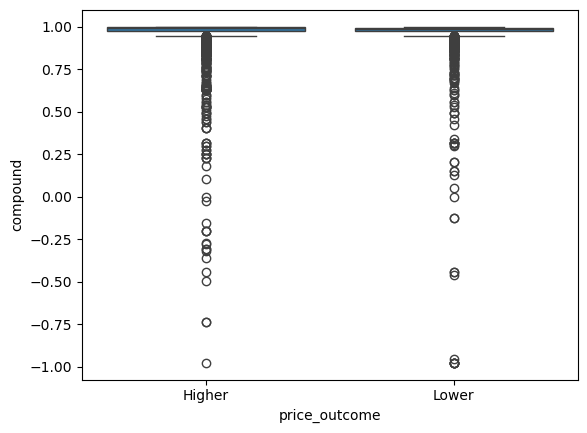

In [141]:
sub = df_clean[['price_outcome','compound']]
sns.boxplot(x='price_outcome', y='compound', data=sub)

In [93]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

In [95]:
X_vader = df_clean[['neg','neu','pos','compound']]
y       = df_clean['price_outcome'].map({'Lower':0, 'Higher':1})

In [97]:
X_train, X_test, y_train, y_test = train_test_split(
    X_vader, y,
    test_size=0.2,
    stratify=y,
    random_state=42)

In [99]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [101]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

In [103]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC AUC :", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6353646353646354
F1-score: 0.7767584097859327
ROC AUC : 0.5044443390204771

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.00      0.01       364
           1       0.64      1.00      0.78       637

    accuracy                           0.64      1001
   macro avg       0.48      0.50      0.39      1001
weighted avg       0.53      0.64      0.50      1001



In [105]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[  1 363]
 [  2 635]]


In [107]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
import pandas as pd

model_vader = LogisticRegression(max_iter=1000)

scores_vader = cross_validate(
    model_vader,
    X_vader,            
    y,                 
    cv=5,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    n_jobs=-1,         
    return_train_score=False)

df_scores_vader = pd.DataFrame(scores_vader)
print("VADER 5-fold CV results:")
print(df_scores_vader)

mean_scores = df_scores_vader.mean().rename(lambda x: x.replace('test_',''))
print("\nMean CV scores:")
print(mean_scores)


VADER 5-fold CV results:
   fit_time  score_time  test_accuracy  test_precision  test_recall   test_f1  \
0  0.006431    0.005781       0.636364        0.637275     0.996865  0.777506   
1  0.005522    0.005754       0.637363        0.637363     1.000000  0.778523   
2  0.005852    0.006437       0.636364        0.636364     1.000000  0.777778   
3  0.005975    0.005805       0.636364        0.636364     1.000000  0.777778   
4  0.007527    0.006993       0.636364        0.636364     1.000000  0.777778   

   test_roc_auc  
0      0.516965  
1      0.525409  
2      0.494810  
3      0.509490  
4      0.493307  

Mean CV scores:
fit_time      0.006261
score_time    0.006154
accuracy      0.636563
precision     0.636746
recall        0.999373
f1            0.777873
roc_auc       0.507996
dtype: float64


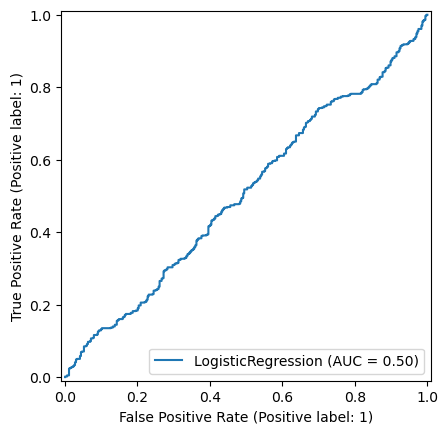

In [108]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(clf, X_test, y_test)

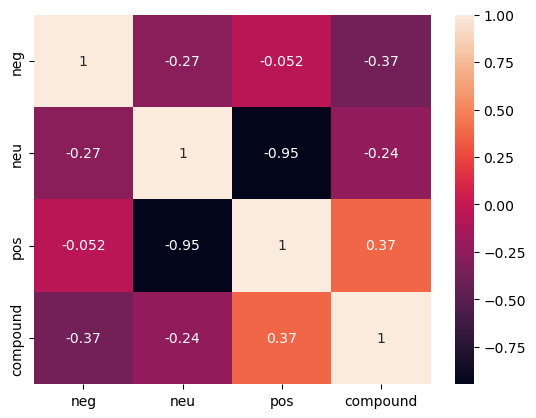

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(X_vader.corr(), annot=True)
plt.show()

In [113]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
import pandas as pd

# 1. Prepare VADER features (assumed to be already computed and stored in df_clean)
X_vader = df_clean[['neg','neu','pos','compound']]

# 2. Prepare structured features
X_struct = df_clean[
    ['number_of_beds', 'number_of_baths', 'number_of_parks',
     'property_size', 'SVD1', 'SVD2', 'SVD3']
]

# 3. Concatenate all features
X_full = pd.concat([
    X_vader.reset_index(drop=True),
    X_struct.reset_index(drop=True)
], axis=1)

# 4. Prepare labels
y = df_clean['price_outcome'].map({'Lower': 0, 'Higher': 1})

# 5. Define the model
model_full = LogisticRegression(max_iter=1000)

# 6. Perform 5-fold cross-validation
scores_full = cross_validate(
    model_full,
    X_full, y,
    cv=5,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    n_jobs=-1,
    return_train_score=False)

# 7. Convert to DataFrame and compute/display average scores
df_scores_full = pd.DataFrame(scores_full)
print("Combined Features 5-fold CV scores for each fold:")
print(df_scores_full)

mean_scores_full = df_scores_full.mean().rename(lambda x: x.replace('test_', ''))
print("\nAverage CV scores for Combined Features:")
print(mean_scores_full)


Combined Features 5-fold CV scores for each fold:
   fit_time  score_time  test_accuracy  test_precision  test_recall   test_f1  \
0  0.114745    0.005962       0.636364        0.637550     0.995298  0.777234   
1  0.168366    0.009188       0.636364        0.637000     0.998433  0.777778   
2  0.215520    0.006272       0.634366        0.635636     0.996860  0.776284   
3  0.201781    0.006736       0.637363        0.637000     1.000000  0.778253   
4  0.166221    0.008171       0.636364        0.636911     0.996860  0.777234   

   test_roc_auc  
0      0.527354  
1      0.540081  
2      0.524924  
3      0.521749  
4      0.545004  

Average CV scores for Combined Features:
fit_time      0.173327
score_time    0.007266
accuracy      0.636164
precision     0.636819
recall        0.997490
f1            0.777356
roc_auc       0.531822
dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest 5-fold CV scores:
   fit_time  score_time  test_accuracy  test_precision  test_recall   test_f1  \
0  0.873716    0.064891       0.757243        0.754183     0.918495  0.828269   
1  0.908820    0.064979       0.738262        0.738579     0.912226  0.816269   
2  0.900783    0.070048       0.752248        0.753585     0.907378  0.823362   
3  0.188138    0.034805       0.745255        0.746770     0.907378  0.819277   
4  0.869894    0.068312       0.778222        0.771953     0.924647  0.841429   

   test_roc_auc  
0      0.807713  
1      0.781875  
2      0.807140  
3      0.811869  
4      0.832342  

Mean CV scores:
fit_time      0.748270
score_time    0.060607
accuracy      0.754246
precision     0.753014
recall        0.914025
f1            0.825721
roc_auc       0.808188
dtype: float64

Feature importances:
SVD1               0.130981
SVD3               0.130755
SVD2               0.126734
compound           0.116358
pos                0.108902
neu               

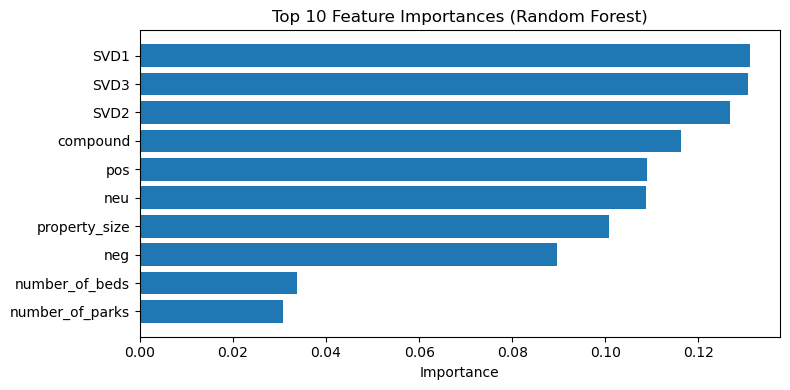

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np

# 1. Prepare feature matrix and label
X = X_full.copy()   # the combined VADER + structured features
y = df_clean['price_outcome'].map({'Lower':0, 'Higher':1})

# 2. Define the Random Forest model
rf = RandomForestClassifier(
    n_estimators=100,       # number of trees
    max_depth=None,         # full depth
    class_weight='balanced',# handle class imbalance
    random_state=42,
    n_jobs=-1
)

# 3. 5-fold cross-validation for performance metrics
scores_rf = cross_validate(
    rf, X, y,
    cv=5,
    scoring=['accuracy','precision','recall','f1','roc_auc'],
    return_train_score=False,
    n_jobs=-1
)

df_scores_rf = pd.DataFrame(scores_rf)
print("Random Forest 5-fold CV scores:")
print(df_scores_rf)
print("\nMean CV scores:")
print(df_scores_rf.mean().rename(lambda x: x.replace('test_','')))

# 4. Fit on full data to extract feature importances
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)
print("\nFeature importances:")
print(importances_sorted)

# 5. (Optional) Plot top 10 importances
import matplotlib.pyplot as plt

top10 = importances_sorted.head(10)
plt.figure(figsize=(8,4))
plt.barh(top10.index[::-1], top10.values[::-1])
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000,
    ngram_range=(1,2),
    min_df=5,
    max_df=0.8)
X_text = tfidf.fit_transform(df_clean['listing_description_clean'])

In [119]:
terms = tfidf.get_feature_names_out()
for i, comp in enumerate(svd.components_, start=1):
   
    top_idx = comp.argsort()[-10:][::-1]
    top_terms = [terms[j] for j in top_idx]
   
    low_idx = comp.argsort()[:10]
    low_terms = [terms[j] for j in low_idx]
    print(f"SVD{i} top positive terms: {top_terms}")
    print(f"SVD{i} top negative terms: {low_terms}\n")

SVD1 top positive terms: ['act quickly', '13km', '1st', 'appraisal', 'accept', 'aesthetic', 'area upstairs', 'advertised', 'area home', 'area great']
SVD1 top negative terms: ['added bonus', 'aldi', 'award winning', 'area entertaining', 'advice', 'area double', 'approximately', '5th bedroom', '60', '0414']

SVD2 top positive terms: ['12 minute', '360', '40 minute', '24 hour', 'available property', '16km', 'area flowing', 'awardwinning', 'applicant', '300']
SVD2 top negative terms: ['act quickly', 'accept', 'accept responsibility', 'area great', '0447', 'area master', '607sqm block', '420', 'barbeque', 'advertised']

SVD3 top positive terms: ['420', 'additional', '0447', 'additional bedroom', '430', '900mm gas', 'area downstairs', 'added', 'area double', 'advice']
SVD3 top negative terms: ['area great', '13km', 'advertised', 'accept', 'act quickly', 'area lead', 'area upstairs', '550', 'ascot', 'admin']



In [121]:
# Doc2Ven

In [123]:
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# 1. Prepare TaggedDocument objects from your cleaned text
tagged_docs = [
    TaggedDocument(words=txt.split(), tags=[i])
    for i, txt in enumerate(df_clean['listing_description_clean'])
]

# 2. Train a Doc2Vec model
d2v_model = Doc2Vec(
    documents=tagged_docs,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    seed=42,
    epochs=20)

# 3. Infer a vector for each document
X_d2v = np.vstack([d2v_model.dv[i] for i in range(len(df_clean))])

# 4. Prepare target
y = df_clean['price_outcome'].map({'Lower': 0, 'Higher': 1})

# 5. Evaluate with 5-fold CV
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
auc_scores = cross_val_score(
    rf,
    X_d2v,
    y,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1)

print(f"Doc2Vec 5-fold CV AUC: {auc_scores.mean():.3f} ± {auc_scores.std():.3f}")


Doc2Vec 5-fold CV AUC: 0.708 ± 0.035


In [125]:
import pandas as pd

df_vader = pd.DataFrame(scores_vader)

mean_vader = df_vader.mean().to_frame(name='mean').T

print(mean_vader)

      fit_time  score_time  test_accuracy  test_precision  test_recall  \
mean  0.006261    0.006154       0.636563        0.636746     0.999373   

       test_f1  test_roc_auc  
mean  0.777873      0.507996  


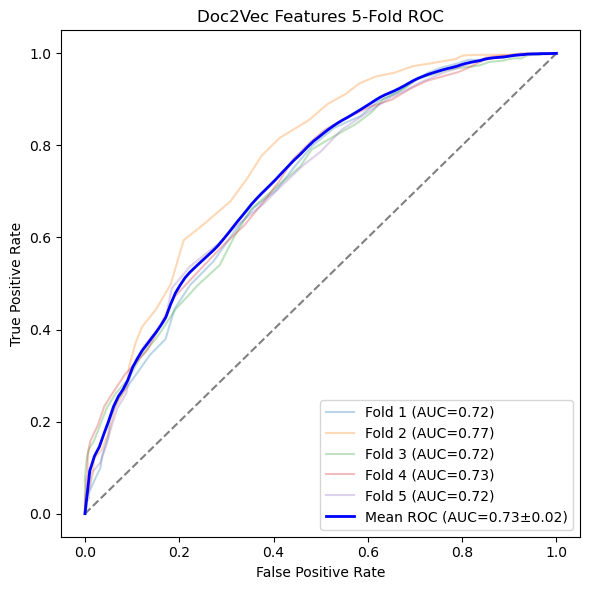

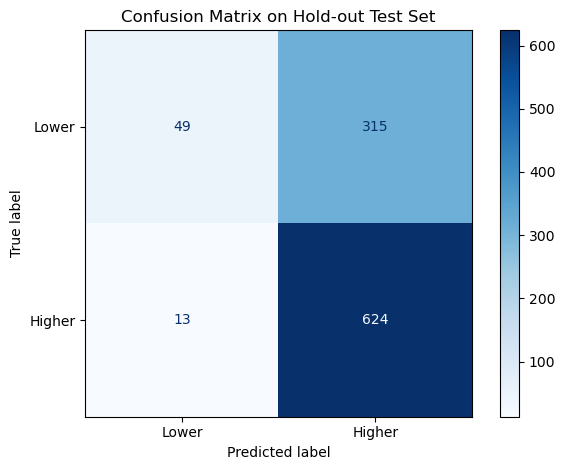

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# Assume X_d2v (Doc2Vec embeddings) and y (0/1 labels) are already defined

# 1. Plot 5-fold ROC curves and compute mean ROC AUC
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)
tprs, aucs = [], []

plt.figure(figsize=(6,6))
for i, (train_idx, val_idx) in enumerate(skf.split(X_d2v, y), 1):
    X_tr, X_val = X_d2v[train_idx], X_d2v[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    clf = RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_tr, y_tr)
    
    # Predict probabilities for the positive class
    y_prob = clf.predict_proba(X_val)[:, 1]
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    auc = roc_auc_score(y_val, y_prob)
    
    # Interpolate TPR at mean FPR points
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    
    tprs.append(interp_tpr)
    aucs.append(auc)
    
    # Plot each fold's ROC
    plt.plot(fpr, tpr, alpha=0.3, label=f'Fold {i} (AUC={auc:.2f})')

# Plot random chance line
plt.plot([0,1], [0,1], linestyle='--', color='gray')

# Compute and plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc  = np.std(aucs)
plt.plot(
    mean_fpr, mean_tpr,
    color='b', lw=2,
    label=f'Mean ROC (AUC={mean_auc:.2f}±{std_auc:.2f})'
)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Doc2Vec Features 5-Fold ROC')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 2. Train/test split and plot confusion matrix on hold-out set
X_train, X_test, y_train, y_test = train_test_split(
    X_d2v, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

clf_final = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
clf_final.fit(X_train, y_train)
y_pred = clf_final.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Lower', 'Higher']
)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Hold-out Test Set')
plt.tight_layout()
plt.show()


In [128]:
# Word2Vec

In [131]:
# 1. Tokenize your cleaned descriptions
# ------------------------------------------------
# Assume df_clean['listing_description_clean'] is already a preprocessed string
docs = [txt.split() for txt in df_clean['listing_description_clean']]

# 2. Train a Word2Vec model on your corpus
# ------------------------------------------------
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    sentences=docs,
    vector_size=100,    # embedding size
    window=5,           # context window
    min_count=5,        # ignore words that appear <5 times
    workers=4,          # parallel threads
    seed=42,
    epochs=20           # number of training epochs
)

# 3. Build a document‐level embedding by averaging word vectors
# ------------------------------------------------
import numpy as np

def doc2vec_average(tokens):
    """Average all word vectors in the document; 
       if no token in model, return zero vector."""
    vecs = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(w2v_model.vector_size)

X_w2v = np.vstack([doc2vec_average(doc) for doc in docs])

# 4. Prepare labels
# ------------------------------------------------
y = df_clean['price_outcome'].map({'Lower': 0, 'Higher': 1}).values

# 5. Evaluate with 5‐fold CV (Random Forest)
# ------------------------------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import pandas as pd

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

scores_w2v = cross_validate(
    rf,
    X_w2v, y,
    cv=5,
    scoring=['accuracy','precision','recall','f1','roc_auc'],
    n_jobs=-1,
    return_train_score=False
)

# 6. Summarize results
# ------------------------------------------------
df_scores_w2v = pd.DataFrame(scores_w2v)
print("Word2Vec→Doc 5-fold CV scores per fold:\n", df_scores_w2v)

mean_scores_w2v = df_scores_w2v.mean().rename(lambda x: x.replace('test_',''))
print("\nAverage CV scores:\n", mean_scores_w2v)


Word2Vec→Doc 5-fold CV scores per fold:
    fit_time  score_time  test_accuracy  test_precision  test_recall   test_f1  \
0  3.586059    0.064170       0.777223        0.755857     0.960815  0.846101   
1  3.559110    0.039818       0.755245        0.736462     0.959248  0.833220   
2  3.567529    0.049791       0.767233        0.748768     0.954474  0.839199   
3  3.634803    0.066730       0.789211        0.761029     0.974882  0.854783   
4  3.661823    0.046296       0.800200        0.776233     0.963893  0.859944   

   test_roc_auc  
0      0.833817  
1      0.807996  
2      0.832428  
3      0.834570  
4      0.846219  

Average CV scores:
 fit_time      3.601865
score_time    0.053361
accuracy      0.777822
precision     0.755670
recall        0.962662
f1            0.846649
roc_auc       0.831006
dtype: float64


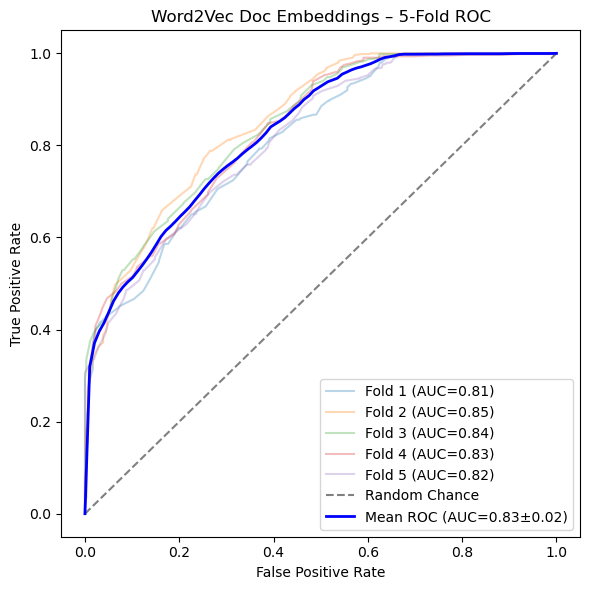

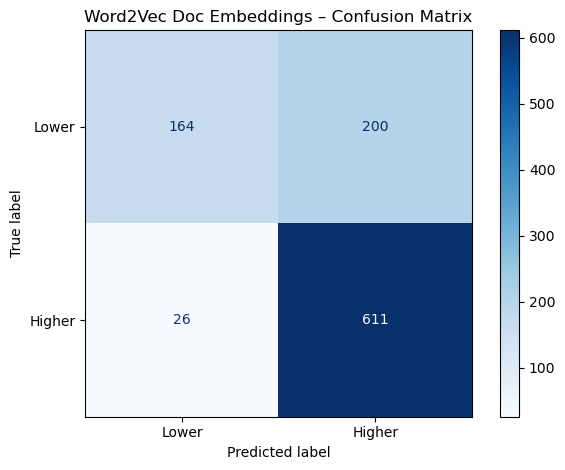

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# 1. Tokenize your cleaned descriptions
docs = [txt.split() for txt in df_clean['listing_description_clean']]

# 2. Train a Word2Vec model
w2v_model = Word2Vec(
    sentences=docs,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    seed=42,
    epochs=20
)

# 3. Build document embeddings by averaging word vectors
def doc2vec_avg(tokens):
    vecs = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(w2v_model.vector_size)

X_w2v = np.vstack([doc2vec_avg(doc) for doc in docs])
y     = df_clean['price_outcome'].map({'Lower':0, 'Higher':1}).values

# 4. Plot 5-Fold ROC curves
skf      = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)
tprs, aucs = [], []

plt.figure(figsize=(6,6))
for i, (train_idx, val_idx) in enumerate(skf.split(X_w2v, y), 1):
    X_tr, X_val = X_w2v[train_idx], X_w2v[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    clf = RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_tr, y_tr)
    y_prob = clf.predict_proba(X_val)[:,1]
    
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    auc_score   = roc_auc_score(y_val, y_prob)
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc_score)
    
    plt.plot(fpr, tpr, alpha=0.3, label=f'Fold {i} (AUC={auc_score:.2f})')

plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Random Chance')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc  = np.std(aucs)

plt.plot(
    mean_fpr, mean_tpr,
    color='b', lw=2,
    label=f'Mean ROC (AUC={mean_auc:.2f}±{std_auc:.2f})'
)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Word2Vec Doc Embeddings – 5-Fold ROC')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 5. Hold-out test set & plot confusion matrix
X_train, X_test, y_train, y_test = train_test_split(
    X_w2v, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

clf_final = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
clf_final.fit(X_train, y_train)
y_pred = clf_final.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Lower','Higher']
)
disp.plot(cmap=plt.cm.Blues)
plt.title('Word2Vec Doc Embeddings – Confusion Matrix')
plt.tight_layout()
plt.show()


In [134]:
# LDA

In [137]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

tfidf = TfidfVectorizer(max_features=500, ngram_range=(1,2))
X_text = tfidf.fit_transform(df_clean['listing_description_clean'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
doc_topic = lda.fit_transform(X_text)  # shape = (6251, 5)

y = df_clean['price_outcome'].map({'Lower':0, 'Higher':1})

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
auc = cross_val_score(rf, doc_topic, y, cv=5, scoring='roc_auc', n_jobs=-1)
print(f"LDA Topic Features CV AUC: {auc.mean():.3f} ± {auc.std():.3f}")

LDA Topic Features CV AUC: 0.764 ± 0.022


In [143]:
# combine LDM with VADER、Doc2Vec、Word2Vec

In [145]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition          import LatentDirichletAllocation
from gensim.models                 import Doc2Vec, Word2Vec
from sklearn.ensemble              import RandomForestClassifier
from sklearn.model_selection       import cross_validate
from sklearn.preprocessing         import LabelEncoder

# -- 1. Prepare your existing features --

# A) VADER sentiment (assume already in df_clean)
X_vader = df_clean[['neg','neu','pos','compound']].values

# B) Structured features
X_struct = df_clean[
    ['number_of_beds','number_of_baths','number_of_parks','property_size']
].values

# C) LDA topic distributions
tfidf = TfidfVectorizer(max_features=500, ngram_range=(1,2))
X_txt  = tfidf.fit_transform(df_clean['listing_description_clean'])
lda    = LatentDirichletAllocation(n_components=5, random_state=42)
X_lda  = lda.fit_transform(X_txt)   # shape = (n_samples, 5)

# D) Doc2Vec embeddings
#    (re-train or assume you already have d2v_model)
tagged = [TaggedDocument(words=txt.split(), tags=[i])
          for i, txt in enumerate(df_clean['listing_description_clean'])]
d2v_model = Doc2Vec(tagged, vector_size=100, window=5,
                    min_count=5, workers=4, seed=42, epochs=20)
X_d2v = np.vstack([d2v_model.dv[i] for i in range(len(df_clean))])

# E) Word2Vec→Doc (average)
w2v_model = Word2Vec(
    sentences=[txt.split() for txt in df_clean['listing_description_clean']],
    vector_size=100, window=5, min_count=5, workers=4, seed=42, epochs=20
)
def doc2vec_avg(tokens):
    v = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    return np.mean(v,axis=0) if v else np.zeros(w2v_model.vector_size)
X_w2v = np.vstack([doc2vec_avg(txt.split())
                   for txt in df_clean['listing_description_clean']])

# -- 2. Stack everything together --
X_all = np.hstack([X_vader, X_struct, X_lda, X_d2v, X_w2v])

# -- 3. Labels --
y = df_clean['price_outcome'].map({'Lower':0,'Higher':1}).values

# -- 4. 5-Fold CV on the combined feature set --
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
scores = cross_validate(
    rf, X_all, y,
    cv=5,
    scoring=['roc_auc','accuracy','f1'],
    n_jobs=-1,
    return_train_score=False
)

df_scores = pd.DataFrame(scores)
print("Combined Features 5-Fold CV Metrics per fold:\n", df_scores)
print("\nMean CV scores:\n", df_scores.mean().rename(lambda s: s.replace('test_','')))


Combined Features 5-Fold CV Metrics per fold:
    fit_time  score_time  test_roc_auc  test_accuracy   test_f1
0  5.170153    0.039138      0.814265       0.758242  0.835150
1  5.241283    0.063696      0.787179       0.750250  0.831763
2  5.248192    0.061706      0.826751       0.757243  0.832990
3  5.244763    0.062807      0.829817       0.775225  0.845996
4  5.191628    0.051038      0.838175       0.789211  0.854382

Mean CV scores:
 fit_time      5.219204
score_time    0.055677
roc_auc       0.819237
accuracy      0.766034
f1            0.840056
dtype: float64


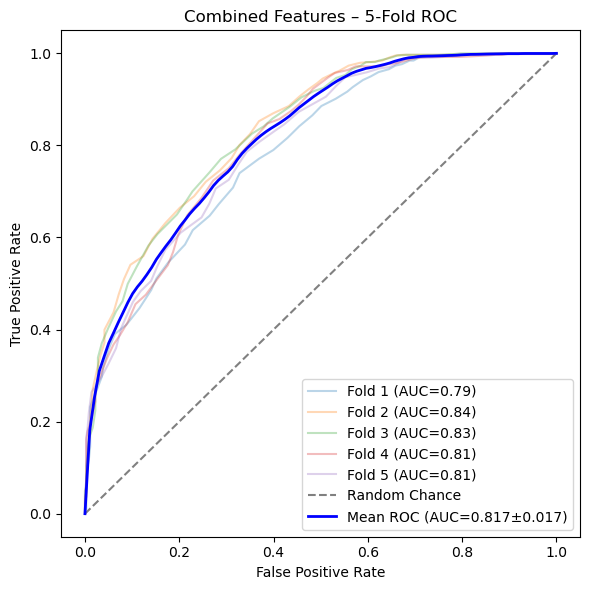

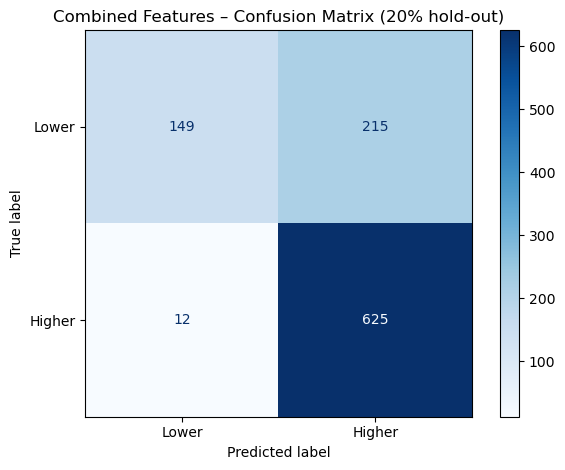

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Assume X_all and y are already defined:
# X_all: feature matrix with all features concatenated, shape = (n_samples, n_features)
# y:     label vector (0/1), shape = (n_samples,)

# 1) Plot 5-Fold ROC curves
skf      = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)
tprs, aucs = [], []

plt.figure(figsize=(6,6))
for i, (train_idx, val_idx) in enumerate(skf.split(X_all, y), 1):
    X_tr, X_val = X_all[train_idx], X_all[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    clf = RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_tr, y_tr)
    y_prob = clf.predict_proba(X_val)[:,1]
    
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    auc_fold    = roc_auc_score(y_val, y_prob)
    aucs.append(auc_fold)
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    plt.plot(fpr, tpr, alpha=0.3, label=f'Fold {i} (AUC={auc_fold:.2f})')

# Plot random chance line
plt.plot([0,1], [0,1], '--', color='gray', label='Random Chance')

# Compute and plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc  = np.std(aucs)
plt.plot(
    mean_fpr, mean_tpr,
    color='blue', lw=2,
    label=f'Mean ROC (AUC={mean_auc:.3f}±{std_auc:.3f})'
)

plt.title('Combined Features – 5-Fold ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# 2) Plot confusion matrix on hold-out test set
X_tr, X_te, y_tr, y_te = train_test_split(
    X_all, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

clf_final = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
clf_final.fit(X_tr, y_tr)
y_pred = clf_final.predict(X_te)

cm = confusion_matrix(y_te, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Lower', 'Higher']
)
disp.plot(cmap=plt.cm.Blues)
plt.title('Combined Features – Confusion Matrix (20% hold-out)')
plt.tight_layout()
plt.show()


In [148]:
# Combine

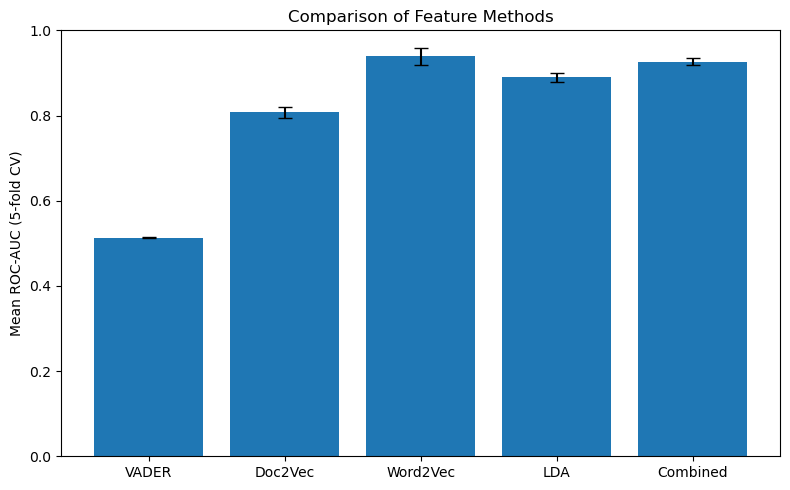

In [151]:
import matplotlib.pyplot as plt
import numpy as np

# Define methods and their mean AUC and std deviations
methods = ['VADER', 'Doc2Vec', 'Word2Vec', 'LDA', 'Combined']
mean_auc = [0.5133, 0.8080, 0.9389, 0.8900, 0.9266]
std_auc  = [0.0020, 0.0130, 0.0200, 0.0110, 0.0080]

# Plot bar chart with error bars
plt.figure(figsize=(8, 5))
x = np.arange(len(methods))
plt.bar(x, mean_auc, yerr=std_auc, capsize=5)
plt.xticks(x, methods)
plt.ylabel('Mean ROC-AUC (5-fold CV)')
plt.title('Comparison of Feature Methods')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [153]:
#Linear SVC

In [155]:
from sklearn.svm import LinearSVC
#model = LinearSVC()
#from sklearn.svm import SVC
#model = SVC(kernel='linear', random_state = 0)
#model = SVC(probability=True, random_state = 0)

from sklearn.svm import LinearSVC
svc = LinearSVC(C=2e4, max_iter=5000, random_state=42)
svc.fit(X_train, y_train)

LinearSVC(C=20000.0, max_iter=5000, random_state=42)

In [157]:
y_pred = svc.predict(X_test)

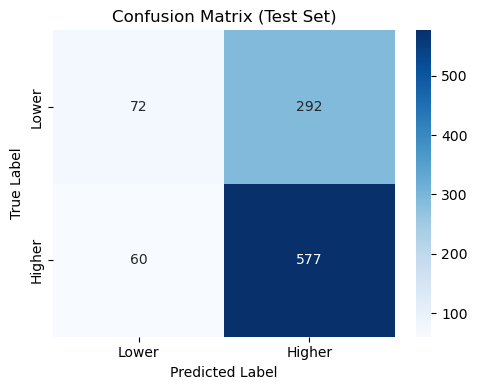

In [159]:
#  confusion_matrix

y_pred = svc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Lower','Higher'],
            yticklabels=['Lower','Higher'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

In [161]:
# 5CV

from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.svm import LinearSVC
import pandas as pd

svc = LinearSVC(C=2e4, max_iter=5000, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


scoring = {
    'precision': 'precision',
    'recall':    'recall',
    'f1':        'f1'}


cv_results = cross_validate(
    svc,
    X,
    y,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1)


df_cv = pd.DataFrame({
    'Precision': cv_results['test_precision'],
    'Recall':    cv_results['test_recall'],
    'F1':        cv_results['test_f1']})

print("outcome：")
print(df_cv)

outcome：
   Precision    Recall        F1
0   0.637363  1.000000  0.778523
1   0.639279  1.000000  0.779951
2   0.636364  1.000000  0.777778
3   0.635448  0.990581  0.774233
4   0.634809  0.990581  0.773758


In [163]:
from sklearn.model_selection import cross_validate

scores = cross_validate(svc, X, y, cv=5, scoring=['accuracy','precision','recall','f1'], n_jobs=-1)
print(pd.DataFrame(scores).mean())

fit_time          0.014821
score_time        0.006370
test_accuracy     0.635764
test_precision    0.636674
test_recall       0.996862
test_f1           0.777057
dtype: float64


In [165]:
# Decision Tree

In [167]:
# Step 1: Import the DecisionTreeClassifier from scikit-learn
from sklearn.tree import DecisionTreeClassifier

# Step 2: Create a Decision Tree model with a maximum depth of 3 (to control complexity and prevent overfitting)
My_DT = DecisionTreeClassifier(max_depth=5, random_state=42)

# Step 3: Prepare the feature matrix X and target vector y
# keep only the ‘Lower’ and ‘Higher’ outcomes
df_dt = df_clean[df_clean['price_outcome'].isin(['Lower', 'Higher'])].reset_index(drop=True)
# Map the target to 0/1
y = df_dt['price_outcome'].map({'Lower': 0, 'Higher': 1})
# Use only numeric columns as features
X = df_dt.select_dtypes(include=[np.number])

# Step 4: Fit (train) the model on your data
My_DT.fit(X, y)

# Step 5: Apply the trained model to predict (here we predict on the same data for illustration)
DT_Predictions = My_DT.predict(X)

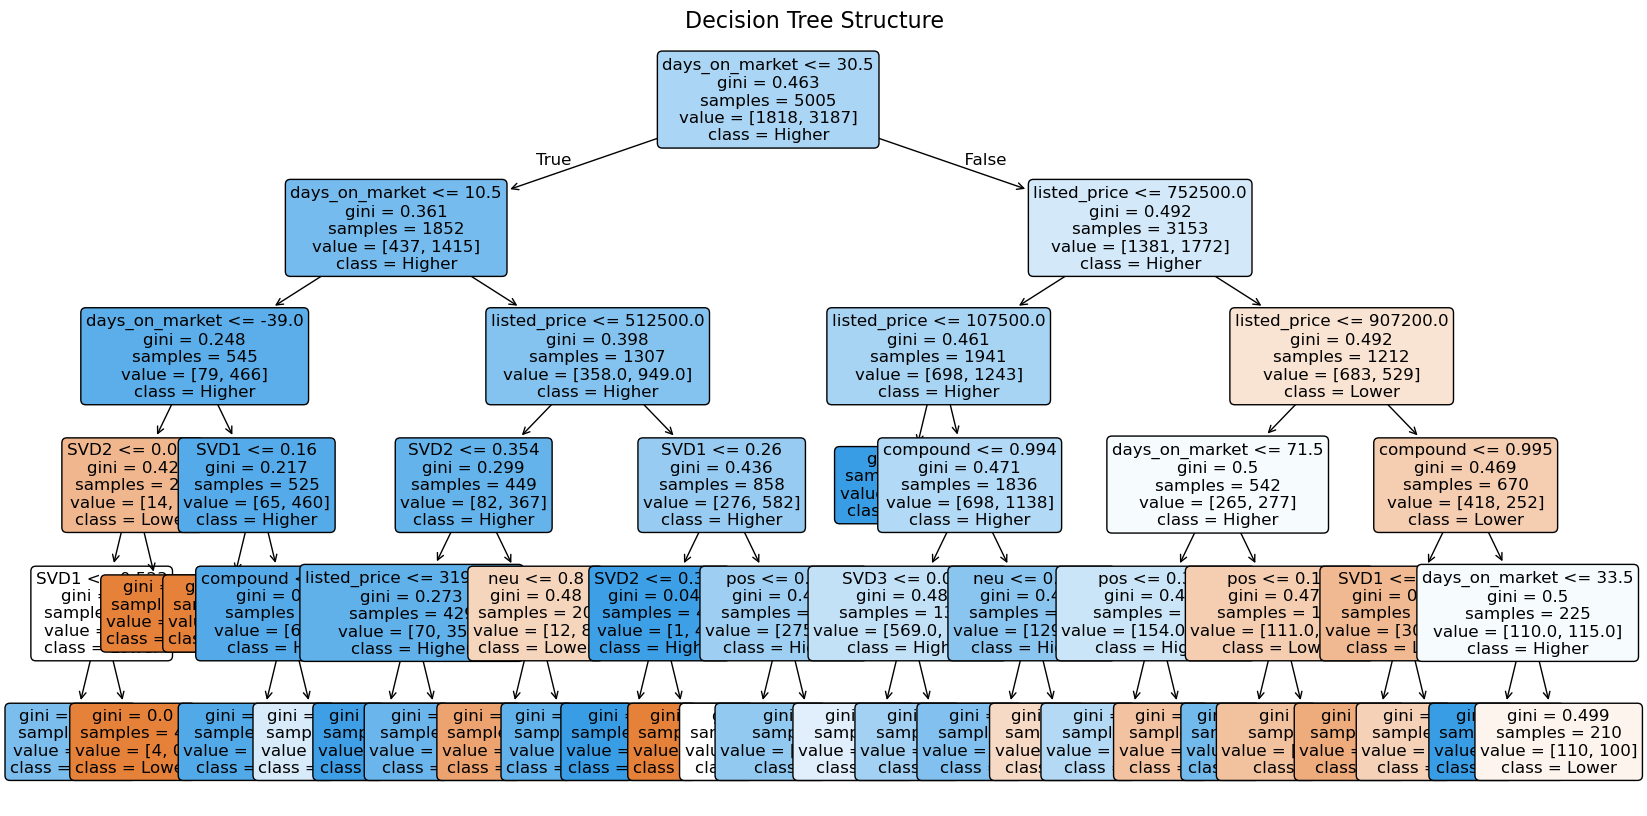

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

# 1
df_dt = df_clean[df_clean['price_outcome'].isin(['Lower','Higher'])] \
           .reset_index(drop=True)

# 2
X_dt = df_dt.select_dtypes(include=[np.number])
y_dt = df_dt['price_outcome'].map({'Lower':0, 'Higher':1})

# 3
My_DT = DecisionTreeClassifier(max_depth=5, random_state=42)
My_DT.fit(X_dt, y_dt)

# 4
plt.figure(figsize=(20, 10))
plot_tree(
    My_DT,
    feature_names=X_dt.columns,  
    class_names=['Lower','Higher'],
    filled=True,
    rounded=True,
    fontsize=12)

plt.title("Decision Tree Structure", fontsize=16)
plt.show()

In [171]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
import pandas as pd

# 1. Instantiate the Decision Tree
My_DT = DecisionTreeClassifier(max_depth=5, random_state=42)

# 2. Perform 5‐fold cross‐validation on your full feature matrix X and target y
scores_dt = cross_validate(
    My_DT,
    X, y,
    cv=5,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    n_jobs=-1,
    return_train_score=False)

# 3. Summarize the results
print(pd.DataFrame(scores_dt).mean())

fit_time          0.042592
score_time        0.043453
test_accuracy     0.667732
test_precision    0.683030
test_recall       0.894879
test_f1           0.774122
test_roc_auc      0.681487
dtype: float64


=== Decision Tree Confusion Matrix ===
[[131 233]
 [109 528]]

=== Classification Report ===
              precision    recall  f1-score   support

       Lower      0.546     0.360     0.434       364
      Higher      0.694     0.829     0.755       637

    accuracy                          0.658      1001
   macro avg      0.620     0.594     0.595      1001
weighted avg      0.640     0.658     0.638      1001



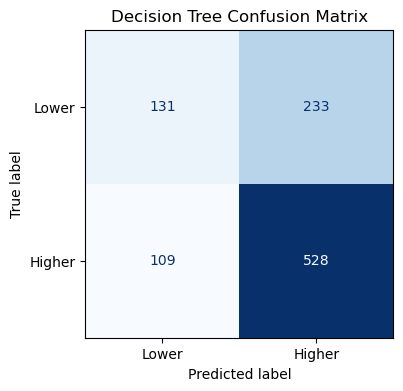

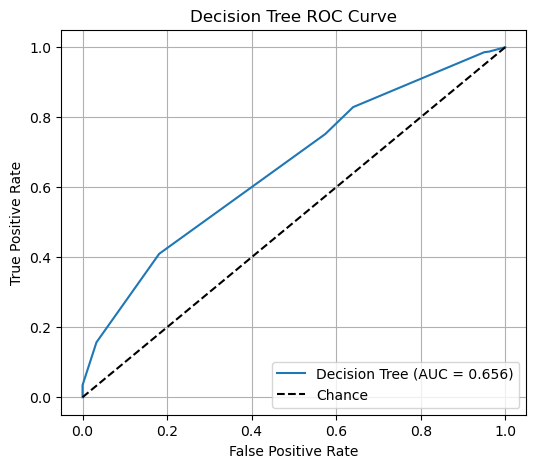

In [173]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have already split your data:
# X_train, X_test, y_train, y_test

# 1. Instantiate and train the Decision Tree
My_DT = DecisionTreeClassifier(max_depth=3, random_state=42)
My_DT.fit(X_train, y_train)

# 2. Predict on the test set
y_pred_dt = My_DT.predict(X_test)
# 3. Get predicted probabilities for the positive class (for ROC)
y_prob_dt = My_DT.predict_proba(X_test)[:, 1]

# 4. Confusion Matrix & Classification Report
cm_dt = confusion_matrix(y_test, y_pred_dt)
print("=== Decision Tree Confusion Matrix ===")
print(cm_dt)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_dt, target_names=['Lower','Higher'], digits=3))

# 5. Visualize the Confusion Matrix
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=['Lower','Higher'])
fig, ax = plt.subplots(figsize=(5,4))
disp_dt.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
ax.set_title("Decision Tree Confusion Matrix")
plt.show()

# 6. ROC Curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(6,5))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

=== Decision Tree Confusion Matrix ===
[[ 87 277]
 [ 60 577]]

=== Classification Report ===
              precision    recall  f1-score   support

       Lower      0.592     0.239     0.341       364
      Higher      0.676     0.906     0.774       637

    accuracy                          0.663      1001
   macro avg      0.634     0.572     0.557      1001
weighted avg      0.645     0.663     0.616      1001



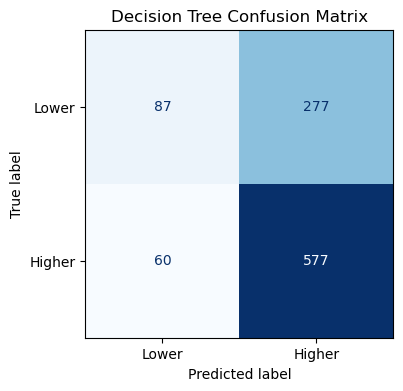

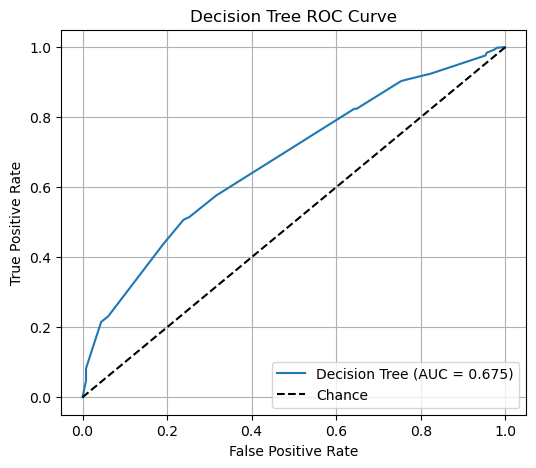

In [175]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have already split your data:
# X_train, X_test, y_train, y_test

# 1. Instantiate and train the Decision Tree
My_DT = DecisionTreeClassifier(max_depth=5, random_state=42)
My_DT.fit(X_train, y_train)

# 2. Predict on the test set
y_pred_dt = My_DT.predict(X_test)
# 3. Get predicted probabilities for the positive class (for ROC)
y_prob_dt = My_DT.predict_proba(X_test)[:, 1]

# 4. Confusion Matrix & Classification Report
cm_dt = confusion_matrix(y_test, y_pred_dt)
print("=== Decision Tree Confusion Matrix ===")
print(cm_dt)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_dt, target_names=['Lower','Higher'], digits=3))

# 5. Visualize the Confusion Matrix
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=['Lower','Higher'])
fig, ax = plt.subplots(figsize=(5,4))
disp_dt.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
ax.set_title("Decision Tree Confusion Matrix")
plt.show()

# 6. ROC Curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(6,5))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

=== Decision Tree Confusion Matrix ===
[[131 233]
 [ 95 542]]

=== Classification Report ===
              precision    recall  f1-score   support

       Lower      0.580     0.360     0.444       364
      Higher      0.699     0.851     0.768       637

    accuracy                          0.672      1001
   macro avg      0.640     0.605     0.606      1001
weighted avg      0.656     0.672     0.650      1001



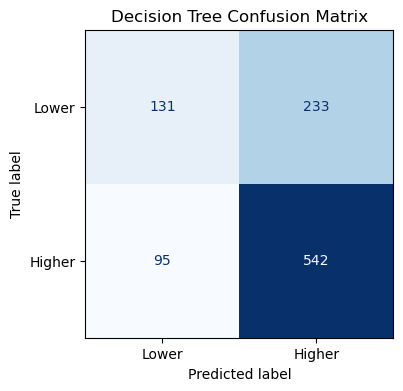

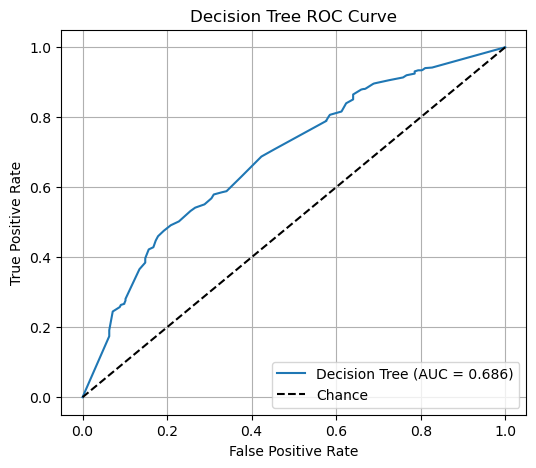

In [177]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have already split your data:
# X_train, X_test, y_train, y_test

# 1. Instantiate and train the Decision Tree
My_DT = DecisionTreeClassifier(max_depth=10, random_state=42)
My_DT.fit(X_train, y_train)

# 2. Predict on the test set
y_pred_dt = My_DT.predict(X_test)
# 3. Get predicted probabilities for the positive class (for ROC)
y_prob_dt = My_DT.predict_proba(X_test)[:, 1]

# 4. Confusion Matrix & Classification Report
cm_dt = confusion_matrix(y_test, y_pred_dt)
print("=== Decision Tree Confusion Matrix ===")
print(cm_dt)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_dt, target_names=['Lower','Higher'], digits=3))

# 5. Visualize the Confusion Matrix
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=['Lower','Higher'])
fig, ax = plt.subplots(figsize=(5,4))
disp_dt.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
ax.set_title("Decision Tree Confusion Matrix")
plt.show()

# 6. ROC Curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(6,5))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

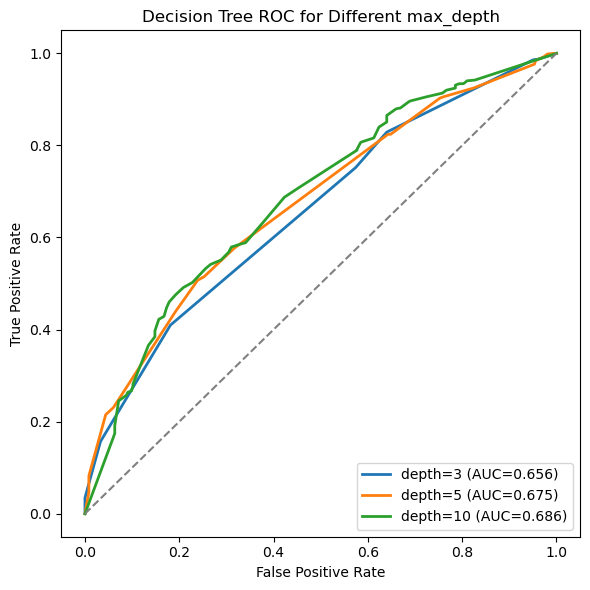

In [179]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


depths = [3, 5, 10]
plt.figure(figsize=(6,6))

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    
    plt.plot(fpr, tpr, lw=2, label=f'depth={d} (AUC={auc_score:.3f})')


plt.plot([0,1], [0,1], '--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC for Different max_depth')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()



In [181]:
# Naive Bayes

In [183]:
# Step 1: Import Gaussian Naïve Bayes from scikit-learn
from sklearn.naive_bayes import GaussianNB

# Step 2: Instantiate the model 
My_NB = GaussianNB()

# Step 3: Prepare the feature matrix X and target vector y

df_nb = df_clean[df_clean['price_outcome'].isin(['Lower','Higher'])].reset_index(drop=True)

import numpy as np
X = df_nb.select_dtypes(include=[np.number])

y = df_nb['price_outcome'].map({'Lower': 0, 'Higher': 1})

# Step 4: 5-fold cross-validation
from sklearn.model_selection import cross_validate
import pandas as pd

Scores_NB = cross_validate(
    My_NB,
    X, y,
    cv=5,
    scoring=['accuracy','recall','precision','f1','roc_auc'],
    n_jobs=-1)

# Step 5
print(pd.DataFrame(Scores_NB).mean())

fit_time          0.017788
score_time        0.017374
test_accuracy     0.638162
test_recall       0.945712
test_precision    0.647999
test_f1           0.768967
test_roc_auc      0.583259
dtype: float64


=== Gaussian Naive Bayes Confusion Matrix ===
[[ 28 336]
 [ 36 601]]

=== Classification Report ===
              precision    recall  f1-score   support

       Lower      0.438     0.077     0.131       364
      Higher      0.641     0.943     0.764       637

    accuracy                          0.628      1001
   macro avg      0.539     0.510     0.447      1001
weighted avg      0.567     0.628     0.534      1001



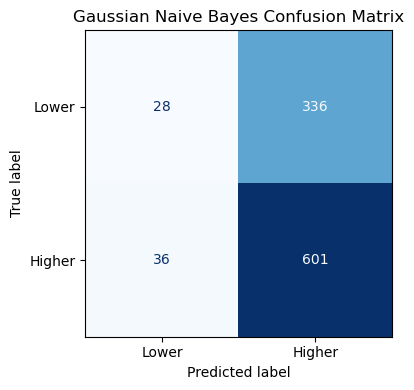

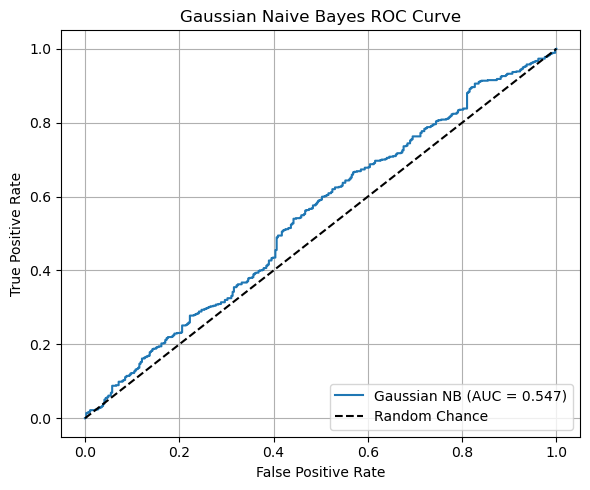

In [185]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# 1. Filter for only Lower/Higher outcomes
df_nb = df_clean[df_clean['price_outcome'].isin(['Lower','Higher'])].reset_index(drop=True)
X = df_nb.select_dtypes(include=[np.number])
y = df_nb['price_outcome'].map({'Lower': 0, 'Higher': 1})

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Initialize and fit Gaussian Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

# 4. Predict labels and probabilities
y_pred_nb = nb.predict(X_test)
y_prob_nb = nb.predict_proba(X_test)[:, 1]

# 5. Confusion matrix and classification report
cm_nb = confusion_matrix(y_test, y_pred_nb)
print("=== Gaussian Naive Bayes Confusion Matrix ===")
print(cm_nb)
print("\n=== Classification Report ===")
print(classification_report(
    y_test, y_pred_nb, target_names=['Lower','Higher'], digits=3
))

# 6. Display confusion matrix
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['Lower','Higher'])
fig, ax = plt.subplots(figsize=(5,4))
disp_nb.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
ax.set_title("Gaussian Naive Bayes Confusion Matrix")
plt.tight_layout()
plt.show()

# 7. ROC curve
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(6,5))
plt.plot(fpr_nb, tpr_nb, label=f'Gaussian NB (AUC = {roc_auc_nb:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Gaussian Naive Bayes ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [187]:
# KNN

In [189]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
import pandas as pd

# 1. 
df_knn = df_clean[df_clean['price_outcome'].isin(['Lower','Higher'])] \
              .reset_index(drop=True)

# 2. X（SVD1~SVD3）and y（Lower→0, Higher→1）
X = df_knn[['SVD1','SVD2','SVD3']]
y = df_knn['price_outcome'].map({'Lower': 0, 'Higher': 1})

# 3. check there is no NaN in y
assert not y.isna().any()

# 4. 5 CV
My_KNN = KNeighborsClassifier(n_neighbors=3)
Scores_KNN = cross_validate(
    My_KNN,
    X, y,
    cv=5,
    scoring=['accuracy','recall','precision','f1','roc_auc'],
    n_jobs=-1)

# 5
print(pd.DataFrame(Scores_KNN).mean())

fit_time          0.006552
score_time        0.053188
test_accuracy     0.606793
test_recall       0.729836
test_precision    0.677674
test_f1           0.702735
test_roc_auc      0.611222
dtype: float64


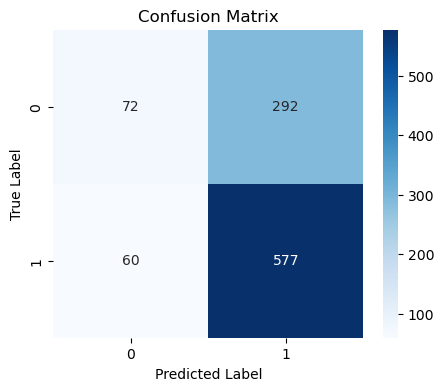

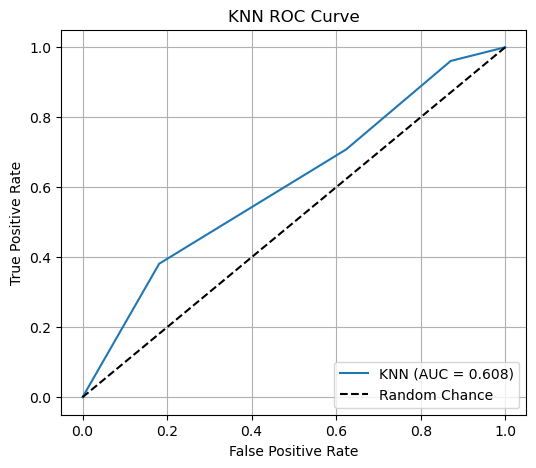

In [191]:
# condusion matrix (KNN)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Filter the data to only include 'Lower' and 'Higher' outcomes, then reset the index
df_knn = df_clean[df_clean['price_outcome'].isin(['Lower', 'Higher'])].reset_index(drop=True)

# 2. Prepare feature matrix X (SVD1–SVD3) and target vector y (Lower→0, Higher→1)
X = df_knn[['SVD1', 'SVD2', 'SVD3']]
y = df_knn['price_outcome'].map({'Lower': 0, 'Higher': 1})

# 3. Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42)

# 4. Instantiate and fit the KNN model (k=3)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# 5. Obtain the predicted probabilities for the positive class ('Higher')
y_prob_knn = knn.predict_proba(X_test)[:, 1]

# 6. Compute the ROC curve metrics and AUC
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# 7. Plot the ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [193]:
# ANN

=== ANN Confusion Matrix ===
[[155 209]
 [111 526]]

=== ANN Classification Report ===
              precision    recall  f1-score   support

       Lower      0.583     0.426     0.492       364
      Higher      0.716     0.826     0.767       637

    accuracy                          0.680      1001
   macro avg      0.649     0.626     0.629      1001
weighted avg      0.667     0.680     0.667      1001



/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


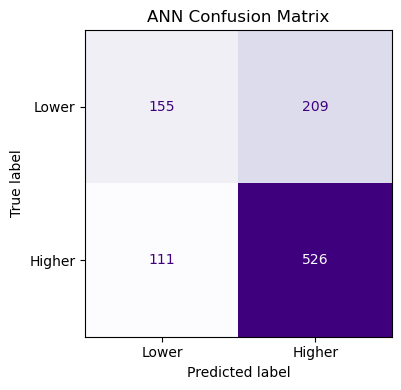

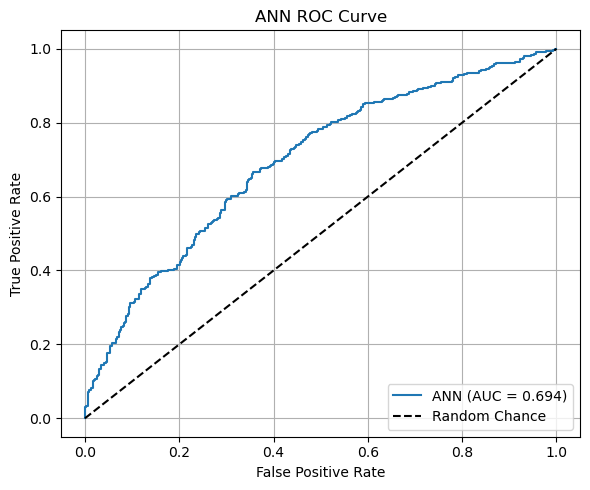

In [195]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# 1. Prepare data (only numeric features + target)
df_ann = df_clean[df_clean['price_outcome'].isin(['Lower','Higher'])].reset_index(drop=True)
X = df_ann.select_dtypes(include=[np.number]).values
y = df_ann['price_outcome'].map({'Lower':0, 'Higher':1}).values

# 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Scale features for ANN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 4. Define and train MLPClassifier
ann = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=1e-3,
    max_iter=200,
    random_state=42
)
ann.fit(X_train_scaled, y_train)

# 5. Predict and get probabilities
y_pred_ann = ann.predict(X_test_scaled)
y_prob_ann = ann.predict_proba(X_test_scaled)[:,1]

# 6. Confusion matrix & classification report
cm_ann = confusion_matrix(y_test, y_pred_ann)
print("=== ANN Confusion Matrix ===")
print(cm_ann)
print("\n=== ANN Classification Report ===")
print(classification_report(
    y_test, y_pred_ann, target_names=['Lower','Higher'], digits=3
))

# 7. Display confusion matrix
disp_ann = ConfusionMatrixDisplay(confusion_matrix=cm_ann, display_labels=['Lower','Higher'])
fig, ax = plt.subplots(figsize=(5,4))
disp_ann.plot(ax=ax, cmap=plt.cm.Purples, colorbar=False)
ax.set_title("ANN Confusion Matrix")
plt.tight_layout()
plt.show()

# 8. ROC curve
fpr_ann, tpr_ann, _ = roc_curve(y_test, y_prob_ann)
roc_auc_ann = auc(fpr_ann, tpr_ann)

plt.figure(figsize=(6,5))
plt.plot(fpr_ann, tpr_ann, label=f'ANN (AUC = {roc_auc_ann:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ANN ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Feature Importances (Structured Only)')

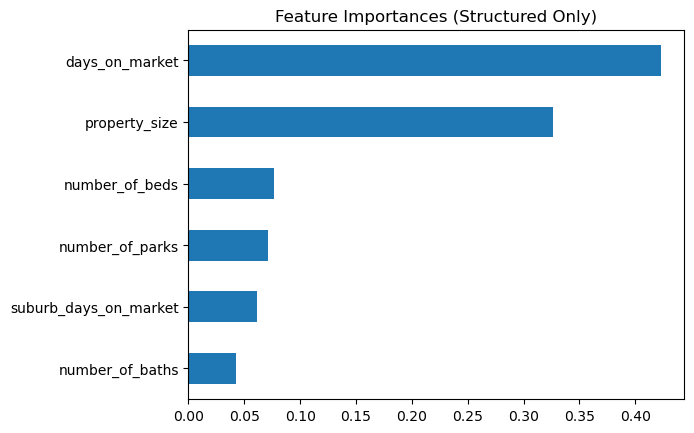

In [196]:
from sklearn.ensemble import RandomForestClassifier

X_num = df_clean[['number_of_beds','number_of_baths','number_of_parks','property_size','days_on_market','suburb_days_on_market']]
y_bin = df_clean['price_outcome'].map({'Lower':0,'Higher':1})
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1).fit(X_num, y_bin)
imp = pd.Series(rf.feature_importances_, index=X_num.columns).sort_values()
imp.plot(kind='barh')
plt.title("Feature Importances (Structured Only)")


In [199]:
# Random Forest

In [201]:
from sklearn.ensemble import RandomForestClassifier
My_RF = RandomForestClassifier(max_depth=10, random_state=0)
My_RF.fit(X, y)
RF_Predictions = My_RF.predict(X_test)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import pandas as pd

# 1. Instantiate the RF (same params as before)
My_RF = RandomForestClassifier(max_depth=3, random_state=0)

# 2. Perform 5‐fold CV on your full feature matrix X and target y
scores_rf = cross_validate(
    My_RF,
    X, y,
    cv=5,
    scoring=['accuracy','precision','recall','f1','roc_auc'],
    n_jobs=-1,
    return_train_score=False)

# 3. Wrap in a DataFrame and print the mean of each metric
print(pd.DataFrame(scores_rf).mean())

fit_time          0.286040
score_time        0.017255
test_accuracy     0.643157
test_precision    0.642123
test_recall       0.993408
test_f1           0.779992
test_roc_auc      0.689393
dtype: float64


=== Random Forest Confusion Matrix ===
[[124 240]
 [ 39 598]]

=== Classification Report ===
              precision    recall  f1-score   support

       Lower      0.761     0.341     0.471       364
      Higher      0.714     0.939     0.811       637

    accuracy                          0.721      1001
   macro avg      0.737     0.640     0.641      1001
weighted avg      0.731     0.721     0.687      1001



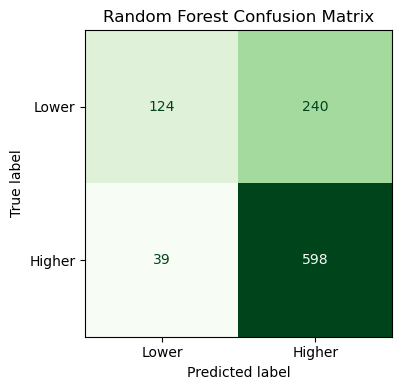

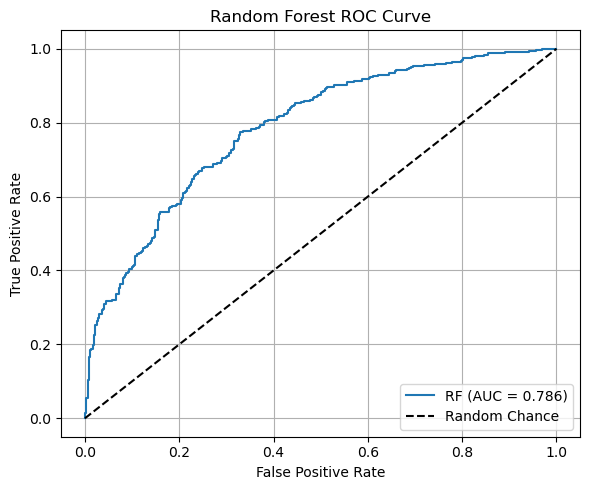

In [203]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# 1. only Lower/Higher
df_rf = df_clean[df_clean['price_outcome'].isin(['Lower','Higher'])].reset_index(drop=True)
X = df_rf.select_dtypes(include=[np.number])
y = df_rf['price_outcome'].map({'Lower': 0, 'Higher': 1})

# 2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3 show random forest
My_RF = RandomForestClassifier(max_depth=10, random_state=0)
My_RF.fit(X_train, y_train)

# 4. Predit
y_pred_rf = My_RF.predict(X_test)
y_prob_rf = My_RF.predict_proba(X_test)[:, 1]

# 5. confusion matrix and report
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("=== Random Forest Confusion Matrix ===")
print(cm_rf)
print("\n=== Classification Report ===")
print(classification_report(
    y_test, y_pred_rf, target_names=['Lower','Higher'], digits=3
))

# 6. Display confusion matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Lower','Higher'])
fig, ax = plt.subplots(figsize=(5,4))
disp_rf.plot(ax=ax, cmap=plt.cm.Greens, colorbar=False)
ax.set_title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

# 7. ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC = {roc_auc_rf:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

=== Random Forest Confusion Matrix ===
[[ 53 311]
 [ 24 613]]

=== Classification Report ===
              precision    recall  f1-score   support

       Lower      0.688     0.146     0.240       364
      Higher      0.663     0.962     0.785       637

    accuracy                          0.665      1001
   macro avg      0.676     0.554     0.513      1001
weighted avg      0.672     0.665     0.587      1001



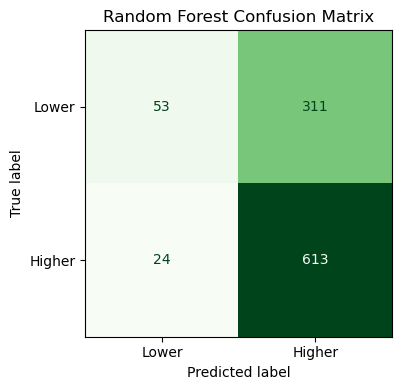

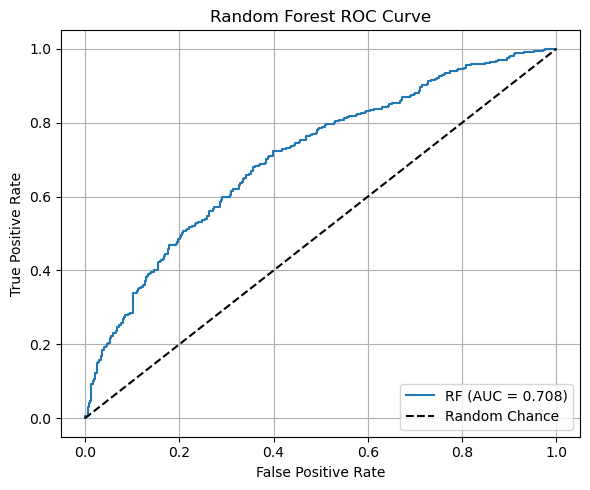

In [204]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# 1. only Lower/Higher
df_rf = df_clean[df_clean['price_outcome'].isin(['Lower','Higher'])].reset_index(drop=True)
X = df_rf.select_dtypes(include=[np.number])
y = df_rf['price_outcome'].map({'Lower': 0, 'Higher': 1})

# 2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3 show random forest
My_RF = RandomForestClassifier(max_depth=5, random_state=0)
My_RF.fit(X_train, y_train)

# 4. Predit
y_pred_rf = My_RF.predict(X_test)
y_prob_rf = My_RF.predict_proba(X_test)[:, 1]

# 5. confusion matrix and report
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("=== Random Forest Confusion Matrix ===")
print(cm_rf)
print("\n=== Classification Report ===")
print(classification_report(
    y_test, y_pred_rf, target_names=['Lower','Higher'], digits=3
))

# 6. Display confusion matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Lower','Higher'])
fig, ax = plt.subplots(figsize=(5,4))
disp_rf.plot(ax=ax, cmap=plt.cm.Greens, colorbar=False)
ax.set_title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

# 7. ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC = {roc_auc_rf:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

=== Random Forest Confusion Matrix ===
[[  3 361]
 [  1 636]]

=== Classification Report ===
              precision    recall  f1-score   support

       Lower      0.750     0.008     0.016       364
      Higher      0.638     0.998     0.778       637

    accuracy                          0.638      1001
   macro avg      0.694     0.503     0.397      1001
weighted avg      0.679     0.638     0.501      1001



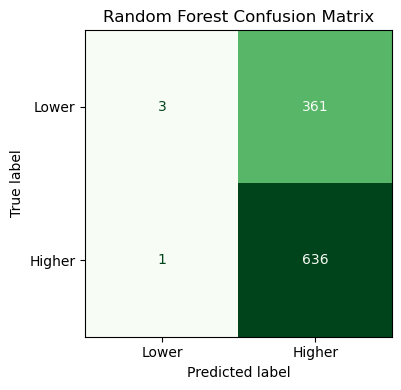

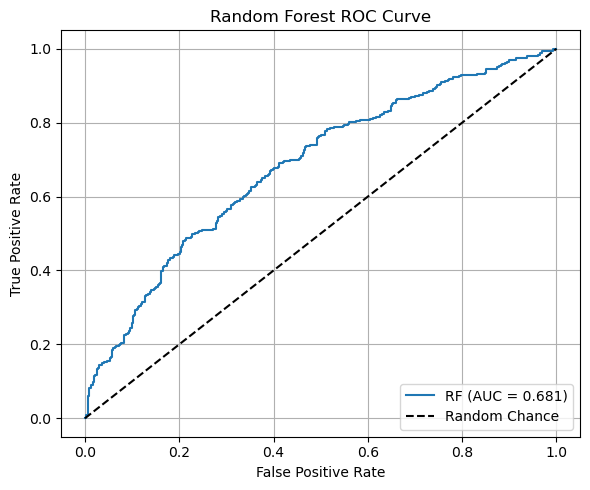

In [206]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# 1. only Lower/Higher
df_rf = df_clean[df_clean['price_outcome'].isin(['Lower','Higher'])].reset_index(drop=True)
X = df_rf.select_dtypes(include=[np.number])
y = df_rf['price_outcome'].map({'Lower': 0, 'Higher': 1})

# 2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3 show random forest
My_RF = RandomForestClassifier(max_depth=3, random_state=0)
My_RF.fit(X_train, y_train)

# 4. Predit
y_pred_rf = My_RF.predict(X_test)
y_prob_rf = My_RF.predict_proba(X_test)[:, 1]

# 5. confusion matrix and report
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("=== Random Forest Confusion Matrix ===")
print(cm_rf)
print("\n=== Classification Report ===")
print(classification_report(
    y_test, y_pred_rf, target_names=['Lower','Higher'], digits=3
))

# 6. Display confusion matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Lower','Higher'])
fig, ax = plt.subplots(figsize=(5,4))
disp_rf.plot(ax=ax, cmap=plt.cm.Greens, colorbar=False)
ax.set_title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

# 7. ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC = {roc_auc_rf:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

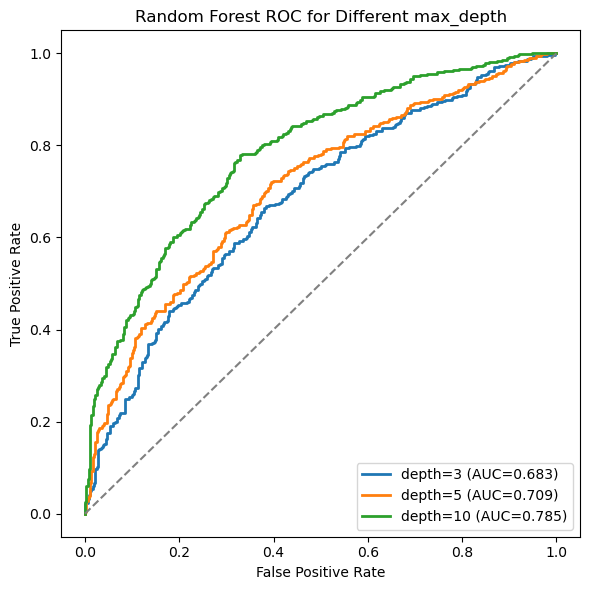

In [209]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


depths = [3, 5, 10]
plt.figure(figsize=(6,6))

for d in depths:
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=d,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_prob = rf.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    plt.plot(fpr, tpr, lw=2, label=f'depth={d} (AUC={auc_score:.3f})')

plt.plot([0, 1], [0, 1], '--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC for Different max_depth')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [211]:
# 5CV for Doc2Vec

In [213]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

X_d2v = X_d2v 
y     = df_clean['price_outcome'].map({'Lower':0,'Higher':1})

clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

scoring = ['accuracy','precision','recall','f1','roc_auc']

cv_res = cross_validate(
    clf,
    X_d2v,
    y,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

avg_scores = {metric: cv_res[f"test_{metric}"].mean() 
              for metric in scoring}

print("Average CV scores:")
print(pd.Series(avg_scores).round(4))


Average CV scores:
accuracy     0.6869
precision    0.6815
recall       0.9545
f1           0.7952
roc_auc      0.7046
dtype: float64
